In [6]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

TEST_IMAGES_PATH = "./data/test2014/test2014"  # Directory with training images

In [7]:
import torchvision.transforms as transforms
from model import EncoderCNN, DecoderRNN

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [8]:
from vocabulary_class import Vocabulary

torch.serialization.add_safe_globals([Vocabulary])

vocab = torch.load("models/vocab.pkl", weights_only=False)
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(
    256,
    512,
    len(vocab)
).to(device)

encoder.load_state_dict(torch.load("models/encoder.pth", weights_only=True, map_location=device))
decoder.load_state_dict(torch.load("models/decoder.pth", weights_only=True, map_location=device))

d:\AIML\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AIML\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [9]:
import torch


def generate_caption(image, encoder, decoder, vocab):
    encoder.eval()
    decoder.eval()
    image = image.unsqueeze(0).to(device)
    feature = encoder(image)              # [1, 256]
    feature = feature.unsqueeze(1)        # [1, 1, 256]

    # 2. Start sequence with <start> token
    start_token = vocab.word2idx["<start>"]
    end_token = vocab.word2idx["<end>"]

    sampled_ids = []
    inputs = torch.LongTensor([[start_token]]).to(image.device)

    # 3. FIRST STEP: concatenate image feature + embedding(<start>)
    embeddings = decoder.embed(inputs)     # [1,1,256]
    lstm_input = torch.cat((feature, embeddings), dim=1)  # [1,2,256]

    hiddens, states = decoder.lstm(lstm_input)

    outputs = decoder.linear(hiddens[:, -1, :])
    predicted = outputs.argmax(dim=1).item()
    sampled_ids.append(predicted)

    # 4. NEXT STEPS: only feed predicted tokens (NO concatenation!)
    inputs = torch.LongTensor([[predicted]]).to(image.device)

    for _ in range(20):
        embeddings = decoder.embed(inputs)  # [1,1,256]

        hiddens, states = decoder.lstm(embeddings, states)
        outputs = decoder.linear(hiddens[:, -1, :])
        
        predicted = outputs.argmax(dim=1).item()
        sampled_ids.append(predicted)
        
        if predicted == end_token:
            break

        inputs = torch.LongTensor([[predicted]]).to(image.device)

    words = [vocab.idx2word[id] for id in sampled_ids]
    return " ".join(words)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.5877128].


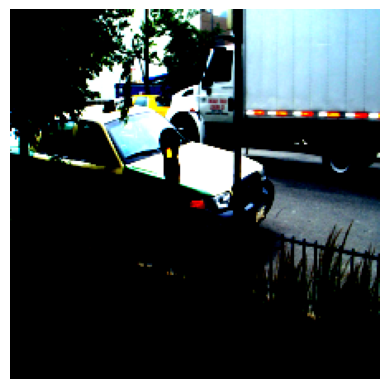

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6897851..2.6051416].


Image: 000000000001.jpg
Caption: man a and on truck down road city . <end>



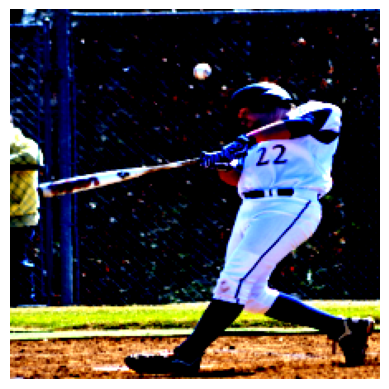

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


Image: 000000000016.jpg
Caption: boy a and baseball on field a <end>



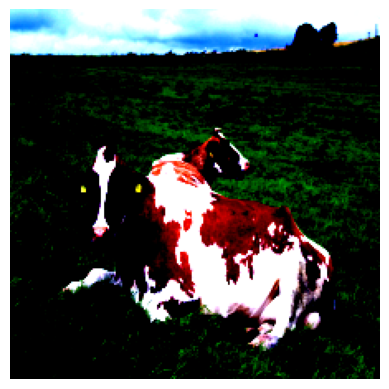

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.5877128].


Image: 000000000019.jpg
Caption: brown white black white brown white black white black <end>



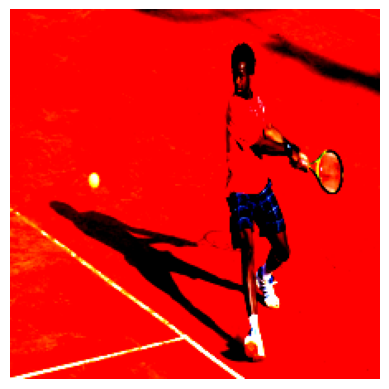

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.5877128].


Image: 000000000057.jpg
Caption: man a and ball a on court a tennis <end>



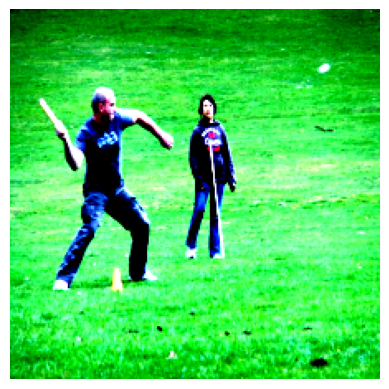

Image: 000000000063.jpg
Caption: men a and are a of and are soccer . are . are the are on grass <end>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


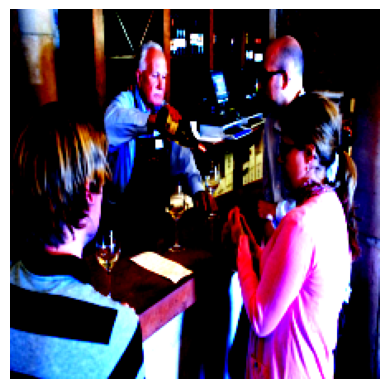

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.465708].


Image: 000000000069.jpg
Caption: woman a and child a of cake a <end>



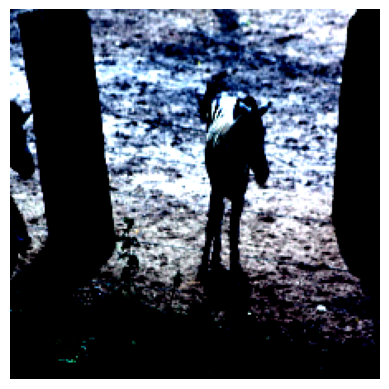

Image: 000000000080.jpg
Caption: zebra in field to in area trees the . <end>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.5702832].


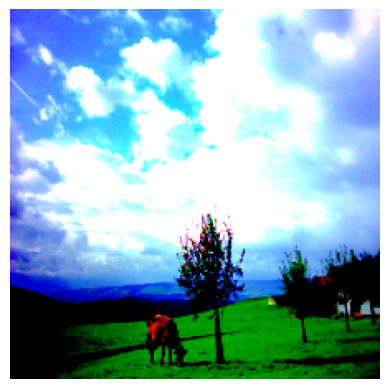

Image: 000000000090.jpg
Caption: group cows in field green with in field <end>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


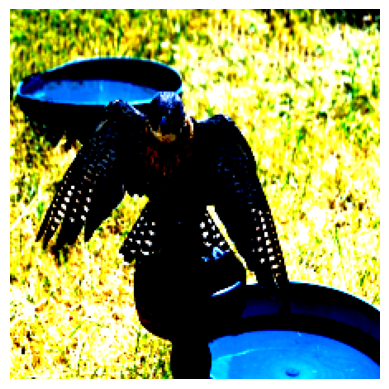

Image: 000000000106.jpg
Caption: young in accents casually on with and on . <end>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


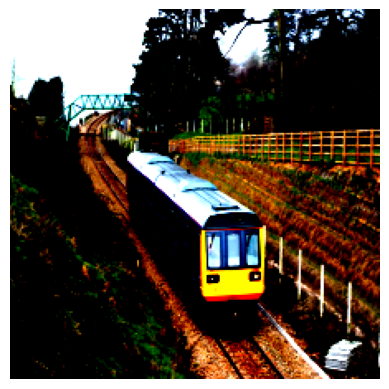

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.465708].


Image: 000000000108.jpg
Caption: train a and train on track trees bushes trees <end>



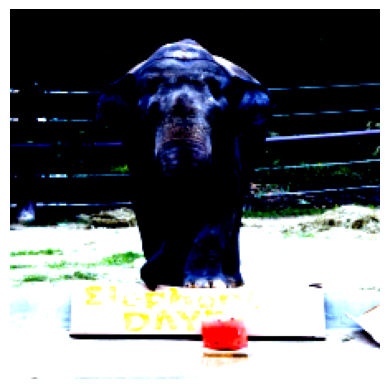

Image: 000000000128.jpg
Caption: elephant in enclosure a and and enclosure a . <end>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


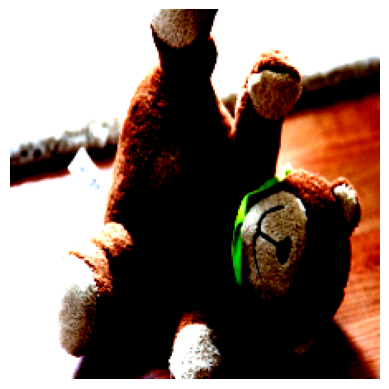

Image: 000000000155.jpg
Caption: teddy with teddy sitting a and teddy on . . <end>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.5702832].


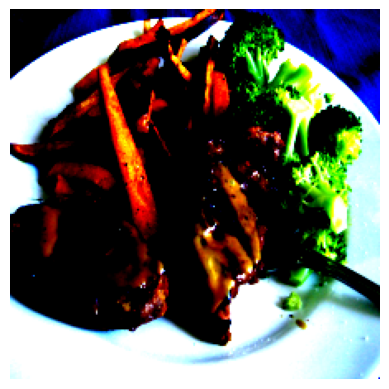

Image: 000000000161.jpg
Caption: plate food a and salad a and sandwich a salad <end>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.186841].


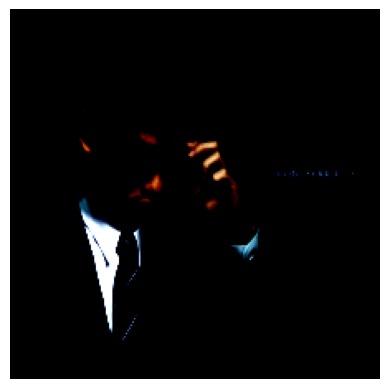

Image: 000000000171.jpg
Caption: man suit tie glasses a and tie a . <end>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


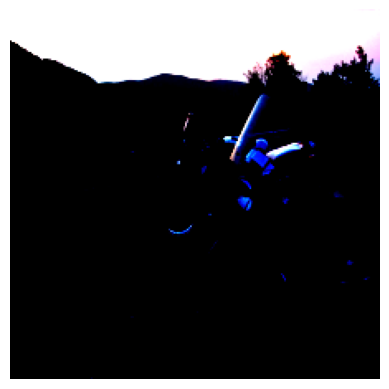

Image: 000000000178.jpg
Caption: man a and motorcycle on side race a . . is on side side <end>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.4134207].


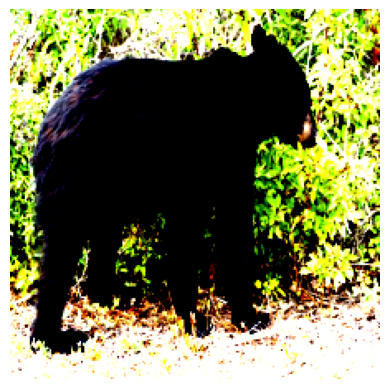

Image: 000000000180.jpg
Caption: black walking a brown next a bear a and <end>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


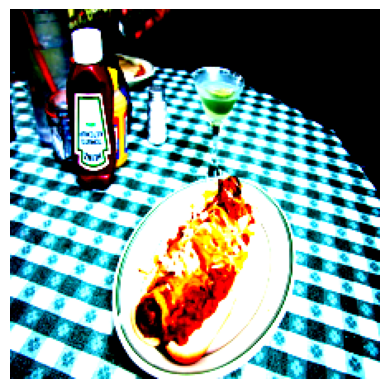

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.235994].


Image: 000000000183.jpg
Caption: pizza on plate to on table beverage a . <end>



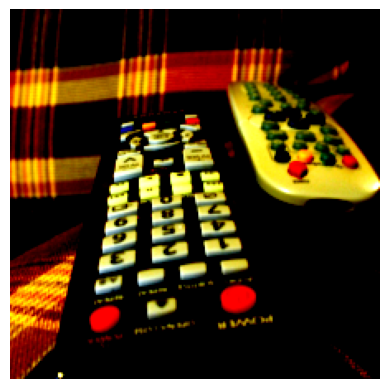

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].


Image: 000000000188.jpg
Caption: remote on table electronic on of . <end>



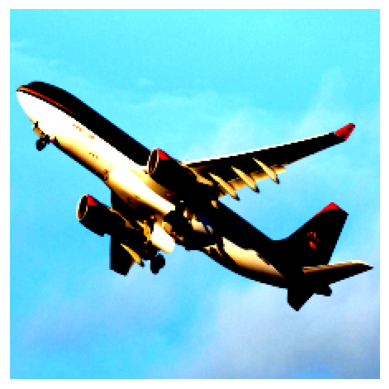

Image: 000000000191.jpg
Caption: large airplane up the of air the . <end>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5702832].


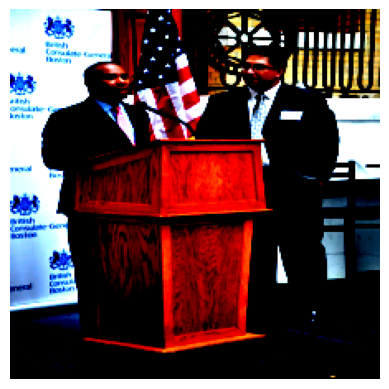

Image: 000000000202.jpg
Caption: man a and on a board a and a <end>



In [10]:
#  test the model on a few images
import os
import matplotlib.pyplot as plt
from PIL import Image

for file_name in os.listdir(TEST_IMAGES_PATH)[:20]:
    # Load image
    img_path = f"{TEST_IMAGES_PATH}/{file_name}"
    image = Image.open(img_path).convert("RGB")

    image = transform(image)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
    
    caption = generate_caption(image, encoder, decoder, vocab)
    print(f"Image: {file_name}\nCaption: {caption}\n")
